# ECE 276C HW3 P2
Mingwei Xu A53270271

In [1]:
import gym
import pybulletgym.envs
import numpy as np
from matplotlib import pyplot as plt

import torch
from torch import nn, optim
from torch.distributions import MultivariateNormal

## Setup CUDA

In [2]:
# setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device :', device)

if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Using device : cpu


## Define Network

In [3]:
class PolicyNetwork(nn.Module):
    """
    Policy Network using MLP
    """
    def __init__(self, env):
        """
        :param env: object, gym environment
        """
        super(PolicyNetwork, self).__init__()
        # get state space and action space dimension
        self.state_space_n = env.observation_space.shape[0] - 1   # should be 8 (TODO: bug in env showing wrong observation space?)
        self.action_space_n = env.action_space.shape[0]   # should be 2

        # define layers
        self.l1 = nn.Linear(self.state_space_n, 48)
        self.l2 = nn.Linear(48, self.action_space_n)

        # self.sigma = nn.Parameter(torch.eye(2))     # initalize cov matrix with grad fn
        self.sigma = nn.Parameter(torch.diag(torch.rand(2)))

    def _check_sigma(self):
        # TODO
        if (self.sigma < 1e-3).any():
            sigma_new = self.sigma.clone()
            sigma_new[sigma_new < 1e-3] = 1e-3
            self.sigma = nn.Parameter(sigma_new)

    def forward(self, x):
        """
        Feed forward
        
        :param x: np array, state
        :return: tensor, softmax probability of action
        """
        # TODO: take sigma as input
        # build neural network
        network = nn.Sequential(
            self.l1,
            nn.Softmax(dim=-1),
            self.l2,
            nn.ReLU())

        self._check_sigma()

        return network(torch.FloatTensor(x).to(device))

## Choose Action

In [4]:
def choose_action(policy_network, state):
    """
    Choose action according to policy on given state

    :param policy_network: object, policy network
    :param state: np array, state
    :returns: tensor (len=2), action; tensor with grad fn, log probability
    """
    probs = policy_network.forward(state)   # mean from policy network output

    cov = policy_network.sigma # TODO: update sigma using sigma = torch.parameter...
    # cov = torch.diag(torch.FloatTensor([0.5,0.5]))

    # if (cov < 1e-3).any():
    #     # regularize
    #     print('rrrrr')
    #     # cov = cov.clone()
    #     # cov[cov < 1e-3] = 1e-3
    #     # policy_network.sigma = nn.Parameter(cov)   # update policy network parameter

    # print('cov:', cov)
    m = MultivariateNormal(probs, cov)
    action = m.sample()
    log_prob = m.log_prob(action)

    return action, log_prob

## Question 2

In [5]:
def reinforce(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99):
    """
    Policy gradient training using reinforce method

    :param env: object, gym environment
    :param policy_network: object, policy network
    :param batch_size: int, batch size
    :param num_episodes: int, number of episodes
    :param lr: float, learning rate
    :param gamma: float (0~1), discount factor
    :return: list of average reward on each episode
    """
    # setup place holders
    average_reward_list = []  # store step over episode

    # define optimizer
    optimizer = optim.Adam(policy_network.parameters(), 
                           lr=lr)

    # train
    for i in range(num_episodes):
        # setup placeholders for each batch
        batch_loss_sum = 0
        batch_traj_counter = 0
        batch_rewards = []

        # setup placeholders for each trajectory
        traj_rewards = []
        traj_log_prob_sum = 0

        # reset environment
        state = env.reset()
        done = False

        # batch
        for step in range(batch_size):
            # exploration
            action, log_prob = choose_action(policy_network, state)
            state_next, reward, done, _ = env.step(action)
            # env.render()

            # store data
            traj_rewards.append(reward)
            traj_log_prob_sum += log_prob

            # move on
            if done or (step == batch_size - 1):
                # trajectory or batch finished, update trajectory
                traj_discounted_return = torch.sum(torch.FloatTensor(traj_rewards).to(device) *
                                                   torch.FloatTensor([gamma ** t for t in range(1, len(traj_rewards) + 1)]).to(device))  # G(t)
                batch_loss_sum += traj_discounted_return * traj_log_prob_sum
                
                # reset state
                batch_rewards.append(np.sum(traj_rewards))
                batch_traj_counter += 1

                traj_rewards = []
                traj_log_prob_sum = 0

                state = env.reset()
            else:
                state = state_next

        # finish batch
        average_batch_reward = np.mean(batch_rewards)
        average_reward_list.append(average_batch_reward)
        loss = - batch_loss_sum / batch_traj_counter
        
        print('Episode [{}/{}] loss: {:.2f}, average reward: {:.2f}, trajectory num: {}'.format(i + 1, num_episodes,
                               loss.item(), average_batch_reward, batch_traj_counter))

        # update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return average_reward_list

In [6]:
def reinforce_with_baseline(env, policy_network, batch_size=500, num_episodes=200, lr=0.01, gamma=0.99, enable_baseline=False):
    """
    Policy gradient training using modified reinforce method with baseline

    :param env: object, gym environment
    :param policy_network: object, policy network
    :param batch_size: int, batch size
    :param num_episodes: int, number of episodes
    :param lr: float, learning rate
    :param gamma: float (0~1), discount factor
    :param enable_baseline: bool, flag to enable baseline, defaults to False
    :return: list of average reward on each episode
    """
    # setup place holders
    average_reward_list = []  # store step over episode

    # define optimizer
    optimizer = optim.Adam(policy_network.parameters(), 
                           lr=lr)

    # train
    for i in range(num_episodes):
        # setup placeholders for each batch
        batch_loss_sum = 0
        batch_traj_counter = 0
        batch_rewards = []

        # setup placeholders for each trajectory
        traj_loss_sum = 0
        traj_rewards = []
        traj_log_prob_list = []

        # reset environment
        state = env.reset()
        done = False

        # batch
        for step in range(batch_size):
            # exploration
            action, log_prob = choose_action(policy_network, state)
            state_next, reward, done, _ = env.step(action)
            # env.render()

            # store data
            traj_rewards.append(reward)
            traj_log_prob_list.append(log_prob)

            # move on
            if done or (step == batch_size - 1):
                # trajectory or batch finished, update trajectory
                # discounted_return_list = []
                discounted_return_list = [sum([gamma ** (t_prime - t) * traj_rewards[t_prime] for t_prime in range(len(traj_rewards))]) \
                                          for t in range(len(traj_rewards))]
                if enable_baseline:
                    # substract discounted return list by its mean
                    discounted_return_list = np.array(discounted_return_list) - np.mean(discounted_return_list)
                # for t in range(len(traj_rewards)):
                #     discounted_return_sum = sum([gamma ** (t_prime - t) * traj_rewards[t_prime] for t_prime in range(len(traj_rewards))])
                #     discounted_return_list.append(discounted_return_sum)

                # sum the traj loss by loop so we do not lose tensor gradient
                traj_loss_sum = 0
                for t in range(len(traj_log_prob_list)):
                    traj_loss_sum += traj_log_prob_list[t] * discounted_return_list[t]
                batch_loss_sum += traj_loss_sum
                
                # reset state
                batch_rewards.append(np.sum(traj_rewards))
                batch_traj_counter += 1

                traj_loss_sum = 0
                traj_rewards = []
                traj_log_prob_list = []

                state = env.reset()
            else:
                state = state_next

        # finish batch
        average_batch_reward = np.mean(batch_rewards)
        average_reward_list.append(average_batch_reward)
        loss = - batch_loss_sum / batch_traj_counter
        if enable_baseline:
            loss = - loss
        
        print('TODO: sigma: ', policy_network.sigma)    # TODO
        print('Episode [{}/{}] loss: {:.2f}, average reward: {:.2f}, trajectory num: {}'.format(i + 1, num_episodes,
                               loss.item(), average_batch_reward, batch_traj_counter))

        # update policy
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return average_reward_list

### Training

In [7]:
env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1', rand_init=False)
# env.render()
# TODO: test
state = env.reset()
print(state)

# setup network
policy_network = PolicyNetwork(env).to(device)
average_reward_list = reinforce_with_baseline(env, policy_network, batch_size=600, num_episodes=500, lr=0.05, gamma=0.9, enable_baseline=False)
# average_reward_list = reinforce(env, policy_network, batch_size=600, num_episodes=500, lr=0.01, gamma=0.9)

056.00, average reward: -43.49, trajectory num: 4
TODO: sigma:  Parameter containing:
tensor([[0.3423, 0.0010],
        [0.0010, 0.4758]], requires_grad=True)
Episode [396/500] loss: -234693632.00, average reward: -36.34, trajectory num: 5
TODO: sigma:  Parameter containing:
tensor([[0.3423, 0.0010],
        [0.0010, 0.4758]], requires_grad=True)
Episode [397/500] loss: -434223936.00, average reward: -46.51, trajectory num: 4
TODO: sigma:  Parameter containing:
tensor([[0.3423, 0.0010],
        [0.0010, 0.4758]], requires_grad=True)
Episode [398/500] loss: -233879072.00, average reward: -34.76, trajectory num: 5
TODO: sigma:  Parameter containing:
tensor([[0.3423, 0.0010],
        [0.0010, 0.4758]], requires_grad=True)
Episode [399/500] loss: -399530880.00, average reward: -46.66, trajectory num: 4
TODO: sigma:  Parameter containing:
tensor([[0.3423, 0.0010],
        [0.0010, 0.4758]], requires_grad=True)
Episode [400/500] loss: -403489312.00, average reward: -46.14, trajectory num: 4


### Plot

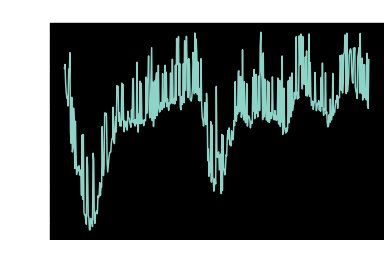

In [8]:
%matplotlib inline
plt.figure()
plt.plot(average_reward_list)
plt.xlabel('episode')
plt.ylabel('average reward')
plt.title('Question 2 Average Rewards at Each Iteration')
plt.savefig('Question_2.png')
plt.show()

### Save Policy

In [9]:
# test policy for one episode
env = gym.make('modified_gym_env:ReacherPyBulletEnv-v1', rand_init=False)
env.render()
state = env.reset()

done = False
step = 0
while not done:
    action, log_prob = choose_action(policy_network, state)
    # action = [1, 0]
    state, reward, done, _ = env.step(action)
    step += 1
print('Finished in {} steps'.format(step))

options= 
Finished in 150 steps
